In [240]:
import pandas as pd
import scipy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
%matplotlib inline
sns.set()

In [241]:
data = loadmat('ex4data1.mat')
weights = loadmat('ex4weights.mat')
x = data['X'].flatten()
y = (np.zeros(50000)).reshape(5000, 10)
m = y.shape[0]
initialTheta = np.concatenate((weights['Theta1'].flatten(), weights['Theta2'].flatten()), axis = 0)
theta1 = initialTheta[:10025].reshape(25, 401)
theta2 = initialTheta[10025:].reshape(10, 26)

In [242]:
for number in range(0, 10):
    if number == 0:
        y[0:500, 9:] = 1
    else:
        y[number * 500:(number + 1) * 500, number - 1:number] = 1
        
y = y.flatten()

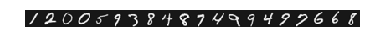

In [243]:
x = x.reshape(5000, 400)
sample = np.random.choice(x.shape[0], 20)
plt.imshow(x[sample, :].reshape(-1, 20).T, cmap='gray')
plt.axis('off');

In [244]:
def sigmoidFunction (z):
    return 1 / (1 + np.exp(-z))

In [246]:
def forwardPropagationFunction (theta, x):
    x = x.reshape(5000, 400)
    theta1 = theta[:10025].reshape(25, 401)
    theta2 = theta[10025:].reshape(10, 26)

    a1 = np.c_[np.ones((x.shape[0], 1)), x]
    z2 = np.dot(a1, theta1.T)

    a2 = np.c_[np.ones((x.shape[0], 1)), sigmoidFunction(z2)]
    z3 = np.dot(a2, theta2.T)

    a3 = sigmoidFunction(z3)
    return np.concatenate([a3.flatten(), z2.flatten(), a2.flatten(), a1.flatten()])

In [247]:
def costFunction (theta, x, y):
    y = y.reshape(5000, 10)
    h = forwardPropagationFunction(theta, x)[:50000].reshape(5000, 10)
    j = np.dot((1 / m), (np.log(h).T.dot(-y) - np.log(1 - h).T.dot(1 - y)))
    costs = []
    for number in range(10):
        costs.append(j[number, number])
    cost = np.sum(np.array(costs))
    return cost

In [248]:
costFunction(initialTheta, x, y)

0.28762916516131892

In [249]:
def regularizedCostFunction (theta, x, y, λ = 1):
    theta1 = theta[:10025].reshape(25, 401)
    theta2 = theta[10025:].reshape(10, 26)
    cost = costFunction(theta, x, y)
    cost += ((λ / (2 * m)) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:]))))
    return cost

In [250]:
regularizedCostFunction(initialTheta, x, y, 1)

0.38376985909092365

In [251]:
def sigmoidGradient (z):
    return sigmoidFunction(z) * (1 - sigmoidFunction(z))

In [252]:
randomTheta = np.random.rand(10285) * 2 * 0.012 - 0.012

In [253]:
def backPropagationFunction (theta, x, y):
    y = y.reshape(5000, 10)
    theta2 = theta[10025:].reshape(10, 26)
    h = forwardPropagationFunction(theta, x)
    a3 = h[:50000].reshape(5000, 10)
    z2 = h[50000:175000].reshape(5000, 25)
    a2 = h[175000:305000].reshape(5000, 26)
    a1 = h[305000:].reshape(5000, 401)
    𝛿3 = a3 - y
    𝛿2 = np.dot(𝛿3, theta2)[:, 1:] * sigmoidGradient(z2)
    Δ2 = np.dot(a2.T, 𝛿3).T
    Δ1 = np.dot(a1.T, 𝛿2).T
    D2 = np.dot(1 / m, Δ2)
    D1 = np.dot(1 / m, Δ1)
    return np.concatenate((D1.flatten(), D2.flatten()))

In [254]:
def regularizedBackPropagationFunction (theta, x, y, λ = 1):
    theta1 = theta[:10025].reshape(25, 401)
    theta2 = theta[10025:].reshape(10, 26)
    
    D1 = backPropagationFunction(theta, x, y)[:10025].reshape(25, 401)
    reg1 = D1[:, 1:] + ((λ / m) * theta1[:, 1:])
    D1 = np.c_[D1[:, :1], reg1]
    
    D2 = backPropagationFunction(theta, x, y)[10025:].reshape(10, 26)
    reg2 = D2[:, 1:] + ((λ / m) * theta2[:, 1:])
    D2 = np.c_[D2[:, :1], reg2]

    return np.concatenate((D1.flatten(), D2.flatten()))

def computeNumericalGradient (theta, ϵ):
    f = []
    epsilonVector1 = np.zeros((10285))
    for number1 in np.nditer(epsilonVector1, op_flags=['readwrite']):
        number1 += ϵ
        thetaPlus = theta + epsilonVector1
        thetaMinus = theta - epsilonVector1
        jPlus = costFunction(thetaPlus, x, y)
        jMinus = costFunction(thetaMinus, x, y)
        f.append((jPlus + jMinus) / (2 * ϵ))
        number1 -= ϵ
    return np.array(f)

In [259]:
def optimize (cost, theta, backPropagation, x, y):
    return sc.optimize.fmin_cg(cost, theta, fprime = backPropagation, args = (x, y), maxiter = 50, full_output = 1, disp = True)[0]

In [260]:
mainTheta = optimize(costFunction, randomTheta, backPropagationFunction, x, y)
mainTheta.shape

         Current function value: 0.347668
         Iterations: 50
         Function evaluations: 115
         Gradient evaluations: 115


(10285,)

In [261]:
output = forwardPropagationFunction(mainTheta, x)[:50000].reshape(5000, 10)
for number in range(0, 10):
    if number == 0:
        output[0:500, 9:] = 1
    else:
        output[number * 500:(number + 1) * 500, number - 1:number] = 1
output

array([[  4.33016354e-07,   3.87985422e-03,   4.48194559e-05, ...,
          1.36045846e-04,   3.61020389e-04,   1.00000000e+00],
       [  7.84606909e-07,   3.62359574e-03,   7.68601885e-05, ...,
          1.17491384e-04,   4.06499611e-04,   1.00000000e+00],
       [  1.12089201e-06,   4.81246368e-03,   2.58810812e-05, ...,
          4.04165238e-03,   1.00211256e-03,   1.00000000e+00],
       ..., 
       [  7.32921929e-03,   4.68564199e-03,   9.92293807e-03, ...,
          9.48120847e-03,   1.00000000e+00,   6.19664300e-07],
       [  6.82008364e-07,   9.97974158e-06,   6.75225880e-06, ...,
          2.59217356e-02,   1.00000000e+00,   8.68826492e-06],
       [  4.43990448e-07,   5.70655312e-04,   2.17859595e-07, ...,
          2.05093693e-03,   1.00000000e+00,   4.10290510e-02]])